# Volatility Models - Project
Cojutti Francesco - Khalil Hassan - Ngoc Truong Nguyen

#3) Implied volatility in the Lifted/Rough Bergomi model

In [ ]:
# Import the necessary package
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
!pip install py_vollib
import py_vollib.black_scholes.implied_volatility as bs_iv

##Exercise 3.1 and 3.2

###3.1) Simulating trajectories of the Lifted Bergomi model
We following the general step below:
- Step 1: Calculate the vector of n factors of c and x using the same formula with Lift Heston model:
\begin{align}
c_i &= \frac{(r_{n}^{1-\alpha} - 1)}{\Gamma(\alpha)\Gamma(2 - \alpha)} r_{n}^{(1-\alpha)(i - \frac{1}{2}n)} \\
x_i &= \frac{(1 - \alpha) r_{n}^{2-\alpha} - 1}{(2 - \alpha) r_{n}^{1-\alpha} - 1} r_{n}^{i-1-\frac{1}{2}n}
\end{align}
- Step 2: Calculate $K_{n}^{2}(t_k)$ at each time grid and then accumulate them using:
\begin{equation}
   K_{n}(t_k) = \sum_{i=1}^{n} c_i e^{-x_i t_k}
\end{equation}
- Step 3: Correlated Brownian motions, dW and dB, are generated using the Cholesky decomposition of the covariance matrix, which incorporates the time step size $\Delta$ and correlation coefficient $\rho$. Multiplying a random vector with normal distribution by the Cholesky matrix yields the correlated increment at each step.
- Step 4: Calculate $Y_t$ at each time grid using implicit scheme:
\begin{equation}
Y_{t_{k+1}}^{i} = \frac{1}{1 + x_i \Delta} \left(Y_{t_k}^{i} + dW\right)
\end{equation}
- Step 5:
1.   Update V at each time step using approximation of stochastic intergral $\sum_{i=1}^{n} c_i Y_{t_{k}}^{i}$ and determinstic intergral for $K_{n}^{2}(t)$ with simple Riemann scheme
2.   Update S at each time step using explicit Euler scheme:
\begin{equation}
  S_{t_{k+1}}^{n} = S_{t_{k}}^{n}\left(1+\sqrt{V_{t_{k}}^{n}} dB\right)
\end{equation}






### 3.2) Using Monte Carlo simulation to price a call option
- Here we create a function Call_Price_Lifted_Bergomi with additional parameter K and nb_scenario
- Next, we run a loop for a function  Sim_Lifted_Bergomi in all nb_screnario, then calculate the payoff for the call of all these screanrio and taking average of them to get the call price

In [ ]:
# Here we create a class Lifted Bergomi, to make this more organized to track all the function
class Lifted_Bergomi_Simulator:
    def __init__(self, T, M, H, S0, epsilon_0, eta, rho, n):
        self.T = T
        self.M = M
        self.H = H
        self.S0 = S0
        self.epsilon_0 = epsilon_0
        self.eta = eta
        self.rho = rho
        self.n = n
        self.delta = T / M
        self.alpha = H + 0.5
        self.rn = 1 + 10 * (n) ** (-0.9)
        self.c = np.array([(self.rn**(1-self.alpha)-1)*(self.rn**((1-self.alpha)*(i-1-self.n/2)))/(gamma(self.alpha)*gamma(1-self.alpha)) for i in range(1,self.n+1)])
        self.x = np.array([(1-self.alpha)*(self.rn**(2-self.alpha)-1)*(self.rn**(i-1-self.n/2))/((2-self.alpha)*(self.rn**(1-self.alpha)-1)) for i in range(1,self.n+1)])
        self.cov = self.delta * np.array([[1, rho], [rho, 1]])
        self.mat = np.linalg.cholesky(self.cov)

    def compute_Kn(self):
      # Update Kn(t) at each time step and store it cumulative value in vector of length M+1
           Kn_vec = np.zeros(self.M+1)
           for j in range(1,self.M+1):
              tk = j*self.delta
              exp_xi = [np.exp(-xi*tk) for xi in self.x]
              Kn_vec[j] = (np.dot(self.c,exp_xi))**2
           return np.cumsum(Kn_vec)

    def  Sim_Lifted_Bergomi(self):
        V = np.zeros(self.M+1)
        S = np.zeros(self.M+1)
        V[0] = self.epsilon_0 # Store the intial value of V
        S[0]=S0 # Store initial value of S
        Y_previous = np.array([0] * self.n)
        Kn_vec =self.compute_Kn()

        for i in range(1, self.M + 1):
            # Generate correlated brownian motions dW and dB at each time step using Cholesky decomposition
            Z = np.dot(self.mat, np.random.randn(2, 1))
            dW = Z[0][0]
            dB = Z[1][0]
            # Temporary update Y(tk) at each time step using implicit scheme
            Y = (1/(1+self.x * self.delta))*(Y_previous+dW)
            Y_previous = Y
            # Calculate the temporary stochastic intergral
            integral = np.dot(self.c, Y)
            # Update V at each step using temporary stochastic intergral and determinstic intergral with simple Riemann scheme
            V[i] = self.epsilon_0 * np.exp(self.eta * np.sqrt(2 * self.H) * gamma(self.H + 0.5) * integral
                                         - self.H * (self.eta ** 2) * (gamma(self.H + 0.5) ** 2)*Kn_vec[i]*self.delta)
            # Update S at each step using explicit Euler scheme
            S[i] = S[i - 1] + S[i - 1] * np.sqrt(V[i - 1]) * dB

        return V, S
    def Call_Price_Lifted_Bergomi(self, K, nb_scenario, r=0):
        # Update a temporary sum for payoff from different scenarios and then take average to get the call price
        sum_payoff = 0
        for _ in range(nb_scenario):
            _, S_path = self.Sim_Lifted_Bergomi()
            payoff = np.maximum(S_path[-1] - K, 0)
            sum_payoff += payoff
        return np.exp(-r * self.T) * sum_payoff / nb_scenario

    def plot_iv_vs_log_strike(self, S0, l_K, title, nb_scenario, r=0):
      # Function use to draw the graph between the implied volatility with log strike price
      # for different factor n
        K = [np.exp(h) for h in l_K]
        implied_vol = []
        for strike in K:
            c_price = self.Call_Price_Lifted_Bergomi(strike, nb_scenario, r)
            # Here we derived implied volatility using built-in pyvolib package
            vol = bs_iv.implied_volatility(c_price, S0, strike, self.T, r, flag='c')
            implied_vol.append(vol)

        plt.plot(l_K, implied_vol, label=f'n={self.n}')
        plt.xlabel('Log Strike')
        plt.ylabel('Implied Volatility')
        plt.title(title)
        plt.legend()

### Using given parameters we draw 4 sample trajectories for Vt and St

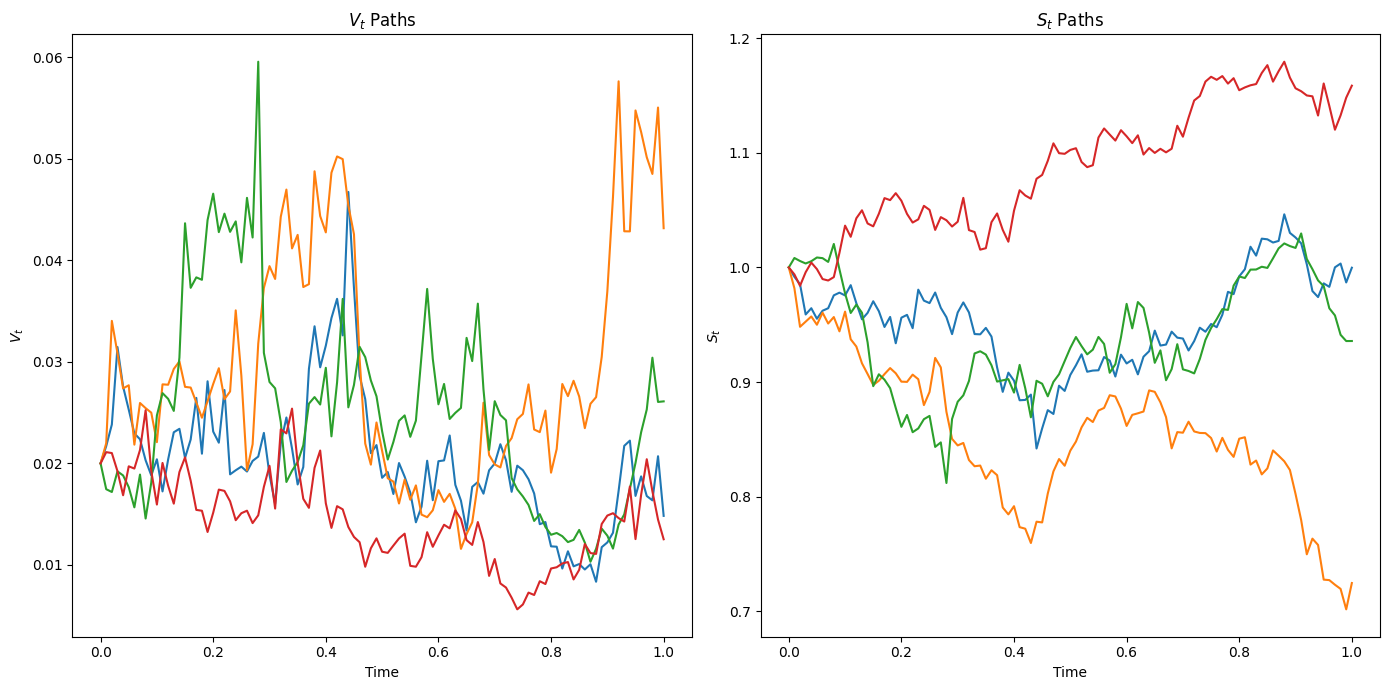

In [ ]:
# Example parameters:
H = 0.1
eta = 1.9
rho = -0.9
S0=1
n=10
T=1
M=100
epsilon_0 = 0.02
nb_scenario = 4
alpha=H+0.5
delta=T/M

simulator = Lifted_Bergomi_Simulator(T, M, H, S0, epsilon_0, eta, rho, n)
time_points = [i*delta for i in range(M+1)]
# Initialize lists to store paths
V_paths = []
S_paths = []

# Run the simulation for each scenario
for _ in range(nb_scenario):
    simulators = Lifted_Bergomi_Simulator(T, M, H, S0, epsilon_0, eta, rho, n)
    V_path, S_path =simulators.Sim_Lifted_Bergomi()
    V_paths.append(V_path)
    S_paths.append(S_path)

# Plotting
plt.figure(figsize=(14, 7))

# Plot each V_t and S_t path
for i in range(nb_scenario):
    plt.subplot(1, 2, 1)
    plt.plot(time_points, V_paths[i])
    plt.title('$V_t$ Paths')
    plt.xlabel('Time')
    plt.ylabel('$V_t$')

    plt.subplot(1, 2, 2)
    plt.plot(time_points, S_paths[i])
    plt.title('$S_t$ Paths')
    plt.xlabel('Time')
    plt.ylabel('$S_t$')

plt.tight_layout()
plt.show()

## 3.3) Plot the implied volatility smile in the Lifted Bergomi model for $n=5,10,20$

### Using T=1 and nb_scenario = 10,000 with 20 equidistant log strikes between -0.3 and 0.3

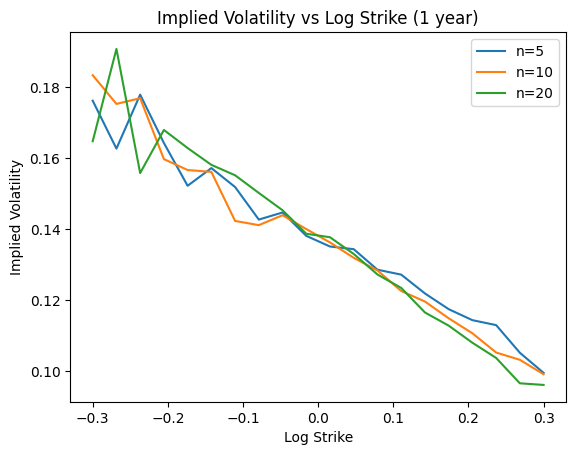

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Plotting for different values of n
l_K = np.linspace(-0.3, 0.3, 20)
nb_scenario = 10000
title = 'Implied Volatility vs Log Strike (1 year)'
n_values = [5,10, 20]
for n in n_values:
    simulator = Lifted_Bergomi_Simulator(T, M, H, S0, epsilon_0, eta, rho, n)
    simulator.plot_iv_vs_log_strike(S0,l_K,title,nb_scenario)
plt.figure(figsize=(12, 8))
plt.show()  # Display the plot